## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [49]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [0]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/gdrive/My Drive/Colab Notebooks/rl/tictactoe/game')

import TCGame_Env1
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [0]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [53]:
t=TCGame_Env1.TicTacToe()
obv=t.step(t.state,[3,1])
print(obv)
Q_state(obv[0])

([nan, nan, nan, 1, nan, nan, nan, 6, nan], -1, False)


'x-x-x-1-x-x-x-6-x'

In [54]:
obv=t.step(obv[0],[4,3])
print(obv)
Q_state(obv[0])

([nan, nan, nan, 1, 3, 4, nan, 6, nan], -1, False)


'x-x-x-1-3-4-x-6-x'

In [55]:
obv=t.step(obv[0],[2,5])
print(obv)
Q_state(obv[0])

([nan, 8, 5, 1, 3, 4, nan, 6, nan], -1, False)


'x-8-5-1-3-4-x-6-x'

In [56]:
obv=t.step(obv[0],[0,7])
print(obv)
Q_state(obv[0])

([7, 8, 5, 1, 3, 4, 2, 6, nan], -1, False)


'7-8-5-1-3-4-2-6-x'

In [57]:
obv=t.step(obv[0],[8,9])
print(obv)
Q_state(obv[0])

([7, 8, 5, 1, 3, 4, 2, 6, 9], 10, True)


'7-8-5-1-3-4-2-6-9'

In [0]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [0]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][str(action)]=0.0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [0]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(state, time):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*time)

    z = np.random.random()
        
    if z > epsilon:
#         print(Q_dict)
        action_str = max(Q_dict[Q_state(state)],key=Q_dict[Q_state(state)].get)   #Exploitation: this gets the action corresponding to max q-value of current state
        
        action=(int(action_str[1]),int(action_str[4]))
        
    else:
        action = (np.random.choice(env.allowed_positions(state)),np.random.choice(env.allowed_values(state)[0]))   #Exploration: randomly choosing and action
    
    return action




#### Tracking the state-action pairs for checking convergence - write your code here

In [0]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)

States_track = collections.defaultdict(dict)
rewards_tracked={'x-x-x-x-x-x-x-x-x': {str((0,1)): [-0.01],str((8,9)):[-0.01]},\
                 'x-x-x-1-x-6-x-x-x':{str((4,3)):[-0.01],str((3,1)):[-0.01]},\
                 'x-x-x-1-3-8-x-x-2':{str((2,5)):[-0.01]},\
                 'x-9-x-x-x-x-x-2-x': {str((0,1)): [-0.01]},\
                 'x-x-5-1-3-8-x-x-2':{str((6,7)):[-0.01]},\
                 '6-8-5-7-x-3-x-4-x': {str((4,1)): [-0.01]}}


In [0]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [('x-x-x-1-x-6-x-x-x',(4,3)),('x-x-x-x-x-x-x-x-x',(0,1)),( 'x-9-x-x-x-x-x-2-x',(0,1))]    #select any 4 Q-values
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][str(action)] = []    #this is an array which will have appended values of that state-action pair for every 2000th episode           
  

In [0]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open("/gdrive/My Drive/Colab Notebooks/rl/tictactoe/game/"+name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [0]:
def save_tracking_states():
    State_track_copy=States_track.copy()
    for state in State_track_copy.keys():
        for action in State_track_copy[state].keys():
            if state in Q_dict and str(action) in Q_dict[state]:
                States_track[state][str(action)].append(Q_dict[state][str(action)])

In [0]:
initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [0]:
#Defining parameters for the experiment

EPISODES = 10000000      
LR = 0.03                   #learning rate
GAMMA = 0.81


# threshold = 2000       #every these many episodes, the 4 Q-values will be stored/appended (convergence graphs)
threshold = 40000
# policy_threshold = 30000    #every these many episodes, the Q-dict will be updated
policy_threshold = 50000

print_threshold=100000

# set the exploration probability to be very high initially. 
epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.00001
decay_rate = 0.00001

### Q-update loop ---write your code here

In [67]:
start_time = time.time()
win_counter=0
tie_counter=0
loss_counter=0
win_ratio=[]
tie_ratio=[]
loss_ratio=[]
deltas=[]
for episode in range(EPISODES):
    ##### Start writing your code from the next line
    env = TCGame_Env1.TicTacToe()  #creating an instance of the class
    initial_state = env.state   
    curr_state = env.state
    add_to_dict(curr_state)
    reward = None
    total_reward = 0
    is_terminal_state=False
    biggest_change=0
    
    while not is_terminal_state:
        curr_action = epsilon_greedy(curr_state, episode)
        curr_state_cp=curr_state.copy()
        next_state, reward, is_terminal_state = env.step(curr_state_cp, curr_action)
        if reward ==10:
            win_counter+=1
        elif reward == -10:
            loss_counter+=1
        elif reward == 0:
            tie_counter+=1
        add_to_dict(next_state)
        if  is_terminal_state:
            total_reward += reward
            break
            
        max_next = max(Q_dict[Q_state(next_state)],key=Q_dict[Q_state(next_state)].get)   #this gets the action corresponding to max q-value of next state
        old_value=Q_dict[Q_state(curr_state)][str(curr_action)]
        Q_dict[Q_state(curr_state)][str(curr_action)] += LR * (reward + (GAMMA*(Q_dict[Q_state(next_state)][max_next] - Q_dict[Q_state(curr_state)][str(curr_action)]) )) 
        new_value=Q_dict[Q_state(curr_state)][str(curr_action)]
        biggest_change=max(biggest_change,np.abs(new_value-old_value))

        curr_state = next_state       
        total_reward += reward
    
    
        #TRACKING REWARDS
        r_copy=rewards_tracked.copy()
        if Q_state(curr_state) in r_copy:     #storing rewards
          if str(curr_action) in r_copy[Q_state(curr_state)]:
            rewards_tracked[Q_state(curr_state)][str(curr_action)].append(total_reward)
          
    deltas.append(biggest_change)
    
    if ((episode+1) % threshold) == 0:   #every 2000th episode
        save_obj(rewards_tracked,'Rewards')   

    #TRACKING Q-VALUES
    if (episode == threshold-1):        #at the 1999th episode
        initialise_tracking_states()
      
    if ((episode+1) % threshold) == 0:   #every 2000th episode
        save_tracking_states()
        save_obj(States_track,'States_tracked')   
    
    #SAVING POLICY
    if ((episode+1)% policy_threshold ) == 0:  #every 30000th episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy')
    win_ratio.append(round(win_counter/(episode+1.0),2))
    loss_ratio.append(round(loss_counter/(episode+1.0),2))
    tie_ratio.append(round(tie_counter/(episode+1.0),2))

#         print results after 100 episodes
    if ((episode+1)% print_threshold ) == 0:
        print('end of episode ',episode+1,"====="," win ratio ", round(win_counter/(episode+1.0),2),"====="," loss ratio ", round(loss_counter/(episode+1.0),2),"====="," tie ratio ", round(tie_counter/(episode+1.0),2))

    
elapsed_time = time.time() - start_time
print('time taken ',elapsed_time)
print('total win ',win_counter, ' total loss ',loss_counter,' total tie ', tie_counter)
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')

end of episode  100000 =====  win ratio  0.59 =====  loss ratio  0.28 =====  tie ratio  0.13
end of episode  200000 =====  win ratio  0.59 =====  loss ratio  0.28 =====  tie ratio  0.13
end of episode  300000 =====  win ratio  0.6 =====  loss ratio  0.28 =====  tie ratio  0.12
end of episode  400000 =====  win ratio  0.6 =====  loss ratio  0.28 =====  tie ratio  0.12
end of episode  500000 =====  win ratio  0.6 =====  loss ratio  0.28 =====  tie ratio  0.12
end of episode  600000 =====  win ratio  0.6 =====  loss ratio  0.28 =====  tie ratio  0.12
end of episode  700000 =====  win ratio  0.6 =====  loss ratio  0.28 =====  tie ratio  0.12
end of episode  800000 =====  win ratio  0.6 =====  loss ratio  0.28 =====  tie ratio  0.12
end of episode  900000 =====  win ratio  0.6 =====  loss ratio  0.28 =====  tie ratio  0.12
end of episode  1000000 =====  win ratio  0.6 =====  loss ratio  0.28 =====  tie ratio  0.12
end of episode  1100000 =====  win ratio  0.61 =====  loss ratio  0.28 ===== 

Text(0.5, 1.0, 'Winning ration of the agent over episodes')

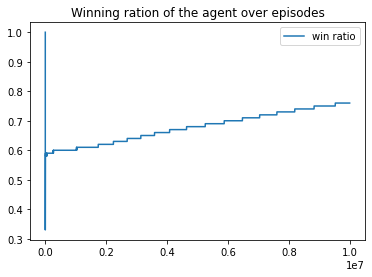

In [68]:
plt.plot(win_ratio, label="win ratio")
plt.legend()
plt.title("Winning ration of the agent over episodes")


Text(0.5, 1.0, 'Convergence Plot')

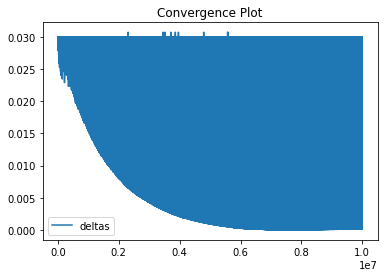

In [69]:
plt.plot(deltas, label="deltas")
plt.legend()
plt.title("Convergence Plot")


In [70]:
deltas[:100]

[0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03]

#### Check the Q-dictionary

In [71]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {'(0, 1)': -2.47973875802557,
              '(0, 3)': -2.4797295246632163,
              '(0, 5)': -2.47974127597105,
              '(0, 7)': -2.4797218290797636,
              '(0, 9)': -2.47975359926855,
              '(1, 1)': -2.479719704928826,
              '(1, 3)': -2.479794590979813,
              '(1, 5)': -2.479724731745409,
              '(1, 7)': -2.47976640628982,
              '(1, 9)': -2.4798654826318014,
              '(2, 1)': -2.479775541522075,
              '(2, 3)': -2.4797324172097404,
              '(2, 5)': -2.479027149868948,
              '(2, 7)': -2.4797367604277762,
              '(2, 9)': -2.479735594759508,
              '(3, 1)': -2.4797579166463986,
              '(3, 3)': -2.4797365289411792,
              '(3, 5)': -2.47974667616403,
              '(3, 7)': -2.4797212636053265,
              '(3, 9)': -2.479737489450718,
              '(4, 1)': -2.4797264410177915,
              '(4, 3)': -2.479762

In [72]:
len(Q_dict)

3423003

In [0]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated

#### Check the states tracked for Q-values convergence
(non-evaluative)

In [0]:
# Write the code for plotting the graphs for state-action pairs tracked

In [75]:
with open('/gdrive/My Drive/Colab Notebooks/rl/tictactoe/game/Policy.pkl', 'rb') as handle:
    Q_dict = pickle.load(handle)
    
with open('/gdrive/My Drive/Colab Notebooks/rl/tictactoe/game/Rewards.pkl', 'rb') as handle:
    rewards_tracked = pickle.load(handle)    

with open('/gdrive/My Drive/Colab Notebooks/rl/tictactoe/game/States_tracked.pkl', 'rb') as handle:
    States_track = pickle.load(handle)    
    
print(len(Q_dict))
print(len(rewards_tracked))
print(len(States_track))

3423003
6
3


In [76]:
rewards_tracked

{'6-8-5-7-x-3-x-4-x': {'(4, 1)': [-0.01]},
 'x-9-x-x-x-x-x-2-x': {'(0, 1)': [-0.01]},
 'x-x-5-1-3-8-x-x-2': {'(6, 7)': [-0.01]},
 'x-x-x-1-3-8-x-x-2': {'(2, 5)': [-0.01]},
 'x-x-x-1-x-6-x-x-x': {'(3, 1)': [-0.01,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   

In [77]:
States_track

defaultdict(dict,
            {'x-9-x-x-x-x-x-2-x': {'(0, 1)': [-0.03,
               -0.08783071469999999,
               -0.08783071469999999,
               -0.11569642833279,
               -0.1694128994997826,
               -0.1694128994997826,
               -0.2205504692071188,
               -0.2451910928053858,
               -0.26923294925021496,
               -0.2926905885834347,
               -0.2926905885834347,
               -0.3155782072808573,
               -0.3379096568439324,
               -0.35969845218262486,
               -0.38095777979458706,
               -0.4017005057455786,
               -0.42193918345596104,
               -0.44168606129798116,
               -0.4609530900084402,
               -0.4797519299212351,
               -0.4980939580241491,
               -0.5159902748441623,
               -0.5334517111654491,
               -0.5334517111654491,
               -0.5504888345841287,
               -0.5833311353752736,
               -0.583331

### Epsilon - decay check

In [0]:
# max_epsilon = 1.0
# min_epsilon = 0.001
time = np.arange(0,10000000)
epsilon = []
for i in time:
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*i))

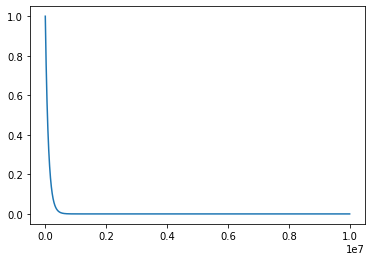

In [79]:
plt.plot(time, epsilon)
plt.show()

In [0]:
# import numpy as np
# for i in range(1,10):
#   print(np.exp(i))